# Classification of Skin Cancers in PyTorch

---

**Intent of notebook:** <br>
This notebook is written with the sole intent of practicing PyTorch.

**Note:**
The comments left may differ from the actual results obtained from running the notebook.

In [1]:
# import misc
import shutil
import pathlib
from typing import Callable

# import data manipulation libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# import image display library
import matplotlib.pyplot as plt

# import deep learning library
import torch
import torchvision
import torchvision.transforms.v2 

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Creating the Train, Validation, and Test Splits

---

A 60-20-20 split will be used for the train, validation, and test split. Each dataset will be placed into its own directory along with a csv file with the labels. The project will be structured as follows:

```
dataset (root directory)
├── train
│   └── ...
├── validation
│   └── ...
├── test
│   └── ...
├── train.csv
├── validation.csv
└── test.csv
```

In [2]:
# import ground truth
records = pd.read_csv("/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv")
records.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# verify that each image only have 1 positive class
num_positive = records[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].sum(axis=1).astype(int)
print(f"Number of classes per image: {', '.join(list(num_positive.astype(str).unique()))}")

Number of classes per image: 1


In [4]:
# compare the number of instances in each class
num_classes = records[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].sum(axis=0).astype(int)
print(num_classes)

MEL      1113
NV       6705
BCC       514
AKIEC     327
BKL      1099
DF        115
VASC      142
dtype: int64


In [5]:
# create column for stratify
records['class'] = records.apply((lambda x: x[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].argmax()), axis=1)

# divide images
remaining, test = train_test_split(records, test_size=0.2, random_state=42, stratify=records["class"])
train, validation = train_test_split(remaining, test_size=0.25, random_state=42, stratify=remaining["class"])

print(f"Number of train images: {len(train)}")
print(f"Number of validation images: {len(validation)}")
print(f"Number of test images: {len(test)}")

Number of train images: 6009
Number of validation images: 2003
Number of test images: 2003


In [6]:
# create train set
print("Creating Train Data")
train.to_csv("/kaggle/working/train.csv", index=False)

# create validation set
print("Creating Validation Data")
validation.to_csv("/kaggle/working/validation.csv", index=False)

# create test set
print("Creating Test Data")
test.to_csv("/kaggle/working/test.csv", index=False)

Creating Train Data
Creating Validation Data
Creating Test Data


# Creating Data Loaders

---

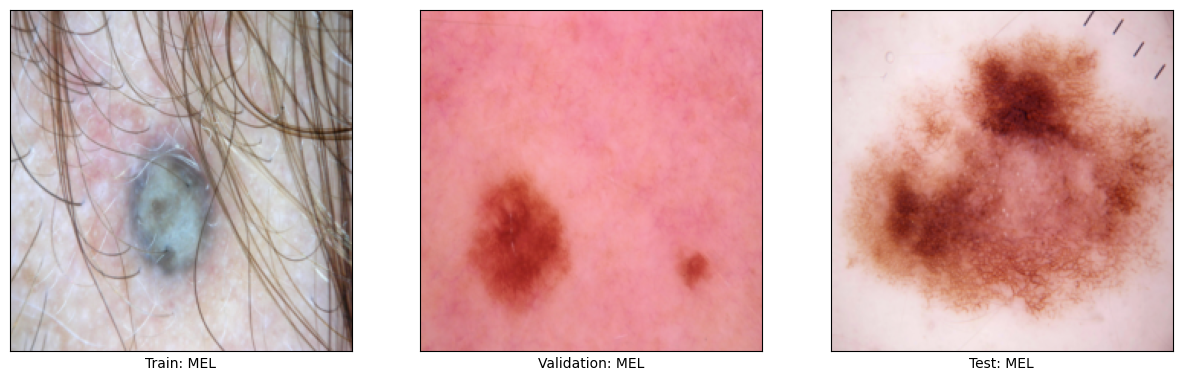

In [7]:
def create_dataset(subset: str):
    df = pd.read_csv(f"/kaggle/working/{subset}.csv")
    X = df['image'].apply(lambda x: '/kaggle/input/ham1000-segmentation-and-classification/images/' + x + '.jpg').astype(str).to_list()
    y = torch.from_numpy(df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].to_numpy()).type(torch.float32)
    return X, y

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, X: torch.tensor, y: torch.tensor):
        super().__init__()
        
        self.X = X
        self.y = y
        
    def __getitem__(self, i: int):
        image = torchvision.io.read_image(self.X[i])
        image = image.type(torch.float32) / 255
        image = torchvision.transforms.v2.functional.resize(image, (224, 224), antialias=True)
        return image, self.y[i]
    
    def __len__(self):
        return len(self.X)

# create datasets
train_ds = ImageDataset(*create_dataset("train"))
validation_ds = ImageDataset(*create_dataset("validation"))
test_ds = ImageDataset(*create_dataset("test"))

# display items in dataset
classes = np.array(['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])
datasets = [train_ds, validation_ds, test_ds]
figure = plt.figure(figsize=(15, 5))
for i, subset in enumerate(["train", "validation", "test"]):
    ds = datasets[i]
    j = np.random.randint(0, len(ds))
    image, label = ds[j]
    image = torch.permute(image, [1, 2, 0]) # change from channels first to channels last format
    label = classes[label.type(torch.int)][0] # extract image label
    plt.subplot(1, 3, i + 1)
    plt.imshow(image.numpy())
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(subset.title() + ": " + label)
plt.show()

In [8]:
# create dataloaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
validation_dl = torch.utils.data.DataLoader(validation_ds, batch_size=64, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)

x, y = next(iter(train_dl))
print(f"Shape of train input: {x.shape}, Shape of train output: {y.shape}")
x, y = next(iter(validation_dl))
print(f"Shape of validation input: {x.shape}, Shape of validation output: {y.shape}")
x, y = next(iter(test_dl))
print(f"Shape of test input: {x.shape}, Shape of test output: {y.shape}")

Shape of train input: torch.Size([64, 3, 224, 224]), Shape of train output: torch.Size([64, 7])
Shape of validation input: torch.Size([64, 3, 224, 224]), Shape of validation output: torch.Size([64, 7])
Shape of test input: torch.Size([64, 3, 224, 224]), Shape of test output: torch.Size([64, 7])


# Training 
---

Basic image augmentation will be applied to increase the effective size of the dataset. Cutmix and mixup will also be used to further augment the dataset for multi-class classification.

In [9]:
# data augmentation
augmentation_model = torch.nn.Sequential(
    torchvision.transforms.v2.RandomHorizontalFlip(0.5),
    torchvision.transforms.v2.RandomVerticalFlip(0.5),
)

# cut/mix up augmentation
cutmix = torchvision.transforms.v2.CutMix(num_classes=7)
mixup = torchvision.transforms.v2.MixUp(num_classes=7)
cutmix_or_mixup = torchvision.transforms.v2.RandomChoice([cutmix, mixup])

# Resnet18 For Multi-Label Classification
---

Treating this classification task as a multi-label classification problem leads to a very interesting outcome. Mainly, the model completely fails at classifying one particular class - `DF`. The model also performs relatively well for `NV` which maybe due to the large number of records in the dataset. However, the number of records alone cannot explain what occurs with `DF` as `VASC` has comparable number of records but a significantly higher prediction accuracy. This then suggests that `DF` is a vary to identify type of skin cancer.

Also, it should be noted that the model's validation loss and accuracy seem to still be increasing, but it could still be trained for more epochs if accuracy was the main objective. However, due to limited time, I will keep it at 15 epochs (this notebook already takes forever to complete). 

**Test results:** <br>
Binary Cross Entropy Loss: 0.0023<br>
Accuracy:
<table style="float:left; margin-left: 1rem;">
    <tr><td><b>Class</b></td><td><b>Accuracy</b></td></tr>
    <tr><td>MEL</td><td>23.57%</td></tr>
    <tr><td>NV</td><td>81.98%</td></tr>
    <tr><td>BCC</td><td>30.27%</td></tr>
    <tr><td>AKIEC</td><td>33.33%</td></tr>
    <tr><td>BKL</td><td>43.65%</td></tr>
    <tr><td>DF</td><td>0.00%</td></tr>
    <tr><td>VASC</td><td>70.00%</td></tr>
</table>


In [10]:
def get_resnet():
    from torchvision.models import resnet18, ResNet18_Weights
    
    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights=weights)
    model.fc = torch.nn.Sequential(
        torch.nn.Dropout(0.2),
        torch.nn.Linear(512, 128),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(128, 32),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(32, 7),
        torch.nn.Sigmoid() 
    )
    preprocess = weights.transforms()
    return model, preprocess

# initialize model, loss and optimizer
resnet, resnet_preprocess = get_resnet()
loss_fn = torch.nn.BCELoss()
optim = torch.optim.Adamax(resnet.parameters())

def train(epochs: int, verbose: int = 1):
    global resnet, resnet_preprocess, loss_fn, optim
    
    # initialize parameters
    num_classes = 7
    
    # track training progress
    progress = {
        "train_loss": [],
        "train_accuracy": [],
        "validation_loss": [],
        "validation_accuracy": []
    }
    
    # move models to the correct device
    resnet = resnet.to(device)
    resnet_preprocess = resnet_preprocess.to(device)
    for epoch in range(epochs):
        # set to train mode
        resnet.train()
        
        # initialize variables to track training metrics
        train_correct = np.zeros(num_classes)
        train_total = np.zeros(num_classes)
        train_loss = 0
        
        # loop through training data
        for X, y in train_dl:
            # move data to the correct device
            X = X.to(device)
            y = y.to(device)
            
            # pass data through models
            X = resnet_preprocess(X)
            X = augmentation_model(X)
            predictions = resnet(X)
            
            # calculate loss
            loss = loss_fn(predictions, y)
            
            # calculate metrics
            predictions = torch.where(predictions.detach() >= 0.5, 1, 0)
            train_correct += (torch.logical_and(predictions, y).sum(axis=0)).cpu().numpy()
            train_total += (torch.logical_or(predictions, y).sum(axis=0)).cpu().numpy()
            train_loss += loss.detach().item()
            
            # update weights
            optim.zero_grad()
            loss.backward()
            optim.step()
        
        # calculate metrics
        train_loss = train_loss / len(train_ds)
        train_accuracy = np.sum(train_correct / train_total * 100) / num_classes # multiply 100 to convert to %
        
        # append to list for plotting
        progress['train_loss'].append(train_loss)
        progress['train_accuracy'].append(train_accuracy)

        # set to evaluation mode
        resnet.eval()
        
        # initialize variables to track validation metrics
        validation_correct = np.zeros(num_classes)
        validation_total = np.zeros(num_classes)
        validation_loss = 0
        
        # inference mode to speed up computations
        with torch.inference_mode():
            # loop through validation data
            for X, y in validation_dl:
               # move data to the correct device
                X = X.to(device)
                y = y.to(device)
                
                # pass data through models
                X = resnet_preprocess(X)
                predictions = resnet(X)
                
                # calculate loss
                loss = loss_fn(predictions, y)
                
                # calculate metrics
                predictions = torch.where(predictions.detach() >= 0.5, 1, 0)
                validation_correct += (torch.logical_and(predictions, y).sum(axis=0)).cpu().numpy()
                validation_total += (torch.logical_or(predictions, y).sum(axis=0)).cpu().numpy()
                validation_loss += loss.detach().item()
            
        # calculate metrics
        validation_loss = validation_loss / len(validation_ds)
        validation_accuracy = np.sum(validation_correct / validation_total * 100) / num_classes # multiply 100 to convert to %
        
        # append to list for plotting
        progress['validation_loss'].append(validation_loss)
        progress['validation_accuracy'].append(validation_accuracy)

        # show progress
        if epoch % verbose == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:<3}: loss: {train_loss:.4f} | accuracy: {train_accuracy:.2f}% | validation loss: {validation_loss:.4f} | validation accuracy: {validation_accuracy:.2f}%")
            
    return progress

# train head only
for param in resnet.parameters():
    param.require_grad = False
for param in resnet.fc.parameters():
    param.require_grad = True
step_1_progress = train(1)

# train full model
for param in resnet.parameters():
    param.require_grad = True
step_2_progress = train(15)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0  : loss: 0.0038 | accuracy: 12.30% | validation loss: 0.0030 | validation accuracy: 11.12%
Epoch 0  : loss: 0.0030 | accuracy: 13.71% | validation loss: 0.0030 | validation accuracy: 13.84%
Epoch 1  : loss: 0.0028 | accuracy: 16.65% | validation loss: 0.0031 | validation accuracy: 15.74%
Epoch 2  : loss: 0.0027 | accuracy: 22.18% | validation loss: 0.0027 | validation accuracy: 28.38%
Epoch 3  : loss: 0.0026 | accuracy: 24.89% | validation loss: 0.0025 | validation accuracy: 29.34%
Epoch 4  : loss: 0.0024 | accuracy: 29.83% | validation loss: 0.0027 | validation accuracy: 30.04%
Epoch 5  : loss: 0.0023 | accuracy: 33.64% | validation loss: 0.0025 | validation accuracy: 36.80%
Epoch 6  : loss: 0.0023 | accuracy: 37.59% | validation loss: 0.0025 | validation accuracy: 31.45%
Epoch 7  : loss: 0.0022 | accuracy: 37.13% | validation loss: 0.0028 | validation accuracy: 34.25%
Epoch 8  : loss: 0.0021 | accuracy: 39.96% | validation loss: 0.0026 | validation accuracy: 30.84%
Epoch 9  :

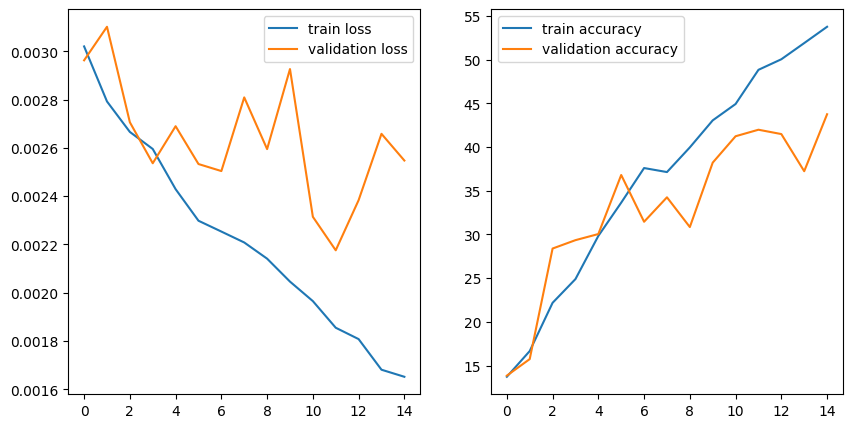

In [11]:
epochs = len(step_2_progress['train_loss'])
plt.figure(figsize=(10, 5))

# plot loss
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), np.asarray(step_2_progress['train_loss']), label='train loss')
plt.plot(np.arange(epochs), np.asarray(step_2_progress['validation_loss']), label='validation loss')
plt.legend()

# plot accuracy
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), np.asarray(step_2_progress['train_accuracy']), label='train accuracy')
plt.plot(np.arange(epochs), np.asarray(step_2_progress['validation_accuracy']), label='validation accuracy')
plt.legend()

In [12]:
# set to evaluation mode
resnet.eval()

# initialize variables to track testing metrics
test_correct = np.zeros(7)
test_total = np.zeros(7)
test_loss = 0

# move models to the correct device
resnet = resnet.to(device)
resnet_preprocess = resnet_preprocess.to(device)

# inference mode to speed up computations
with torch.inference_mode():
    # loop through test data
    for X, y in test_dl:
        # move data to the correct device
        X = X.to(device)
        y = y.to(device)
        
        # pass data through models
        X = resnet_preprocess(X)
        predictions = resnet(X)
        
        # calculate loss
        loss = loss_fn(predictions, y)
        
        # calculate metrics
        predictions = torch.where(predictions.detach() >= 0.5, 1, 0)
        test_correct += (torch.logical_and(predictions, y).sum(axis=0)).cpu().numpy()
        test_total += (torch.logical_or(predictions, y).sum(axis=0)).cpu().numpy()
        test_loss += loss.detach().item()

# calculate metrics
# accuracy in this case is per class not mean accuracy
test_loss = test_loss / len(test_ds)
test_accuracy = test_correct / test_total * 100 # multiply 100 to convert to %
print(f"loss: {test_loss:.4f} | accuracy: {test_accuracy}")

loss: 0.0025 | accuracy: [15.83333333 82.66485384 54.54545455 38.83495146 36.48648649  0.
 68.96551724]


In [13]:
# save model
torch.save(resnet.state_dict(), "resnet.pt")

# move model back to cpu
resnet = resnet.cpu()
resnet_preprocess = resnet_preprocess.cpu()

# Resnet18 for Multi-Class Classification
---

Comparing the results of multi-label to multi-class classification leads to a very obvious conclusion - multi-label classification is a significantly harder task compared to multi-class classification. Interestingly, `DF` also had 0 correct predictions as well. This could suggest an issue with the dataset regarding `DF` records, which ought to be looked into when obtaining more collecting more data.

Also, the model's validation loss and accuracy is still showing a rising trend even after 30 epochs. This model is far from its full potential yet and should be trained even more.

**Test results:** <br>
Cross Entropy Loss: 0.0159 <br>
Accuracy: 79.0% <br>
<table style="float:left; margin-left: 1rem;">
    <tr><td><b>Class</b></td><td><b>Precision</b></td><td><b>Recall</b></td></tr>
    <tr><td>MEL</td><td>0.75</td><td>0.20</td></tr>
    <tr><td>NV</td><td>0.83</td><td>0.97</td></tr>
    <tr><td>BCC</td><td>0.56</td><td>0.78</td></tr>
    <tr><td>AKIEC</td><td>0.53</td><td>0.37</td></tr>
    <tr><td>BKL</td><td>0.67</td><td>0.48</td></tr>
    <tr><td>DF</td><td>0.00</td><td>0.00</td></tr>
    <tr><td>VASC</td><td>0.91</td><td>0.75</td></tr>
</table>

In [14]:
def get_resnet():
    from torchvision.models import resnet18, ResNet18_Weights
    
    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights=weights)
    model.fc = torch.nn.Sequential(
        torch.nn.Dropout(0.2),
        torch.nn.Linear(512, 128),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(128, 32),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(32, 7)
    )
    preprocess = weights.transforms()
    return model, preprocess

# initialize model, loss and optimizer
# label smoothing is recommended with cutmix and mixup
resnet_mc, resnet_preprocess = get_resnet()
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optim = torch.optim.Adamax(resnet_mc.parameters())

def train(epochs: int, verbose: int = 1):
    global resnet_mc, resnet_preprocess, loss_fn, optim
    
    # track training progress
    progress = {
        "train_loss": [],
        "train_accuracy": [],
        "validation_loss": [],
        "validation_accuracy": []
    }
    
    # move models to the correct device
    resnet_mc = resnet_mc.to(device)
    resnet_preprocess = resnet_preprocess.to(device)
    for epoch in range(epochs):
        # set to train mode
        resnet_mc.train()
        
        # initialize variables to track training metrics
        train_correct = 0
        train_loss = 0
        
        # loop through training data
        for X, y in train_dl:
            # move data to the correct device
            X = X.to(device)
            y = y.to(device)
            
            # calculate class
            y = torch.argmax(y, axis=1)
            
            # pass data through models
            X = resnet_preprocess(X)
            X = augmentation_model(X)
            X, aug_y = cutmix_or_mixup(X, y)
            predictions = resnet_mc(X)
            
            # calculate loss
            loss = loss_fn(predictions, y)
            
            # calculate metrics
            train_correct += (torch.argmax(predictions, axis=1) == y).type(torch.int).sum().item()
            train_loss += loss.detach().item()
            
            # update weights
            optim.zero_grad()
            loss.backward()
            optim.step()
            
        # calculate metrics
        train_loss = train_loss / len(train_ds)
        train_accuracy = train_correct / len(train_ds) * 100
        
        # append to list for plotting
        progress['train_loss'].append(train_loss)
        progress['train_accuracy'].append(train_accuracy)
        
        # set to evaluation mode
        resnet_mc.eval()
        
        # initialize variables to track validation metrics
        validation_correct = 0
        validation_loss = 0
        
        # inference mode to speed up computations
        with torch.inference_mode():
            # loop through validation data
            for X, y in validation_dl:
                # move data to the correct device
                X = X.to(device)
                y = y.to(device)
                
                # calculate class
                y = torch.argmax(y, axis=1)
                
                # pass data through models
                X = resnet_preprocess(X)
                predictions = resnet_mc(X)
                
                # calculate loss
                loss = loss_fn(predictions, y)
                
                # calculate metrics
                validation_correct += (torch.argmax(predictions, axis=1) == y).type(torch.int).sum().item()
                validation_loss += loss.detach().item()
               
        # calculate metrics
        validation_loss = validation_loss / len(validation_ds)
        validation_accuracy = validation_correct / len(validation_ds) * 100
        
        # append to list for plotting
        progress['validation_loss'].append(validation_loss)
        progress['validation_accuracy'].append(validation_accuracy)
        
        # show progress
        if epoch % verbose == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:<3}: loss: {train_loss:.4f} | accuracy: {train_accuracy:.2f}% | validation loss: {validation_loss:.4f} | validation accuracy: {validation_accuracy:.2f}%")
            
    return progress


# train head only
for param in resnet_mc.parameters():
    param.require_grad = False
for param in resnet_mc.fc.parameters():
    param.require_grad = True
step_1_progress = train(1)

# train full model
for param in resnet_mc.parameters():
    param.require_grad = True
step_2_progress = train(30)

Epoch 0  : loss: 0.0203 | accuracy: 66.40% | validation loss: 0.0186 | validation accuracy: 66.95%
Epoch 0  : loss: 0.0194 | accuracy: 66.85% | validation loss: 0.0177 | validation accuracy: 66.95%
Epoch 1  : loss: 0.0193 | accuracy: 67.07% | validation loss: 0.0176 | validation accuracy: 69.30%
Epoch 2  : loss: 0.0193 | accuracy: 66.88% | validation loss: 0.0173 | validation accuracy: 66.95%
Epoch 3  : loss: 0.0188 | accuracy: 67.20% | validation loss: 0.0167 | validation accuracy: 70.24%
Epoch 4  : loss: 0.0188 | accuracy: 67.03% | validation loss: 0.0168 | validation accuracy: 68.85%
Epoch 5  : loss: 0.0189 | accuracy: 66.88% | validation loss: 0.0169 | validation accuracy: 66.95%
Epoch 6  : loss: 0.0182 | accuracy: 67.67% | validation loss: 0.0165 | validation accuracy: 71.89%
Epoch 7  : loss: 0.0186 | accuracy: 67.65% | validation loss: 0.0166 | validation accuracy: 70.74%
Epoch 8  : loss: 0.0186 | accuracy: 67.52% | validation loss: 0.0166 | validation accuracy: 70.69%
Epoch 9  :

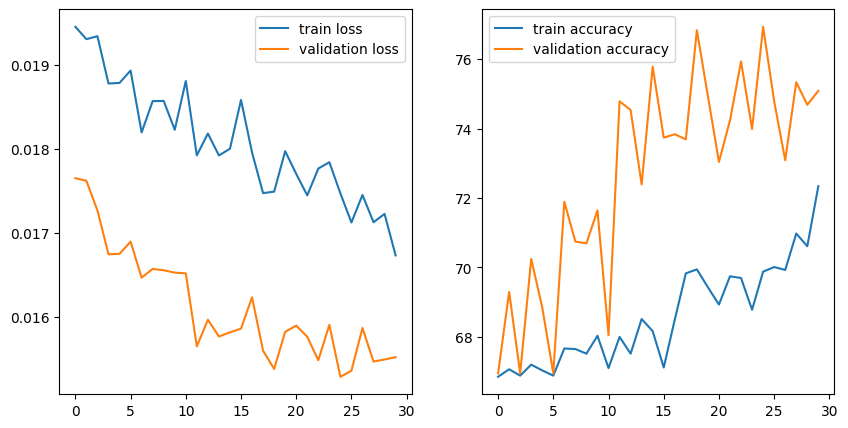

In [15]:
epochs = len(step_2_progress['train_loss'])
plt.figure(figsize=(10, 5))

# plot loss
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), np.asarray(step_2_progress['train_loss']), label='train loss')
plt.plot(np.arange(epochs), np.asarray(step_2_progress['validation_loss']), label='validation loss')
plt.legend()

# plot accuracy
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), np.asarray(step_2_progress['train_accuracy']), label='train accuracy')
plt.plot(np.arange(epochs), np.asarray(step_2_progress['validation_accuracy']), label='validation accuracy')
plt.legend()

In [16]:
# set to evaluation mode
resnet_mc.eval()

# initialize variables to track testing metrics
test_predictions = torch.tensor([])
test_y = torch.tensor([])
test_loss = 0

# move model to the correct device
resnet_mc = resnet_mc.to(device)
resnet_preprocess = resnet_preprocess.to(device)

# inference mode to speed up computations
with torch.inference_mode():
    # loop through the test data
    for X, y in test_dl:
        # move data to the correct device
        X = X.to(device)
        y = y.to(device)
        
        # calculate class
        y = torch.argmax(y, axis=1)
        
        # pass data through models
        X = resnet_preprocess(X)
        predictions = resnet_mc(X)
        
        # calculate loss
        loss = loss_fn(predictions, y)
        
        # calculate metrics
        test_predictions = torch.cat([test_predictions, torch.argmax(predictions.detach().cpu(), axis=1)])
        test_y = torch.cat([test_y, y.detach().cpu()])
        test_loss += loss.detach().item()

# calculate metrics
test_loss = test_loss / len(test_ds)
test_predictions = test_predictions.numpy()
test_y = test_y.numpy()
print(f"loss: {test_loss:.4f}")
print(classification_report(test_y, test_predictions))

loss: 0.0154
              precision    recall  f1-score   support

         0.0       0.43      0.43      0.43       223
         1.0       0.80      0.97      0.88      1341
         2.0       0.80      0.44      0.57       103
         3.0       0.47      0.11      0.18        65
         4.0       0.90      0.20      0.33       220
         5.0       0.00      0.00      0.00        23
         6.0       1.00      0.54      0.70        28

    accuracy                           0.76      2003
   macro avg       0.63      0.38      0.44      2003
weighted avg       0.75      0.76      0.71      2003



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# save model
torch.save(resnet_mc.state_dict(), "resnet_mc.pt")

# move model back to cpu
resnet_mc = resnet_mc.cpu()
resnet_preprocess = resnet_preprocess.cpu()

# Vision Transformer (ViT) for Multi-Label Classification
---

Unsurprisingly, the ViT model performs worse than the resnet18 model on the multi-label classification task. The ViT paper did hint that ViT models do not have the same scale, rotation, etc invariance that convolutional neural networks possess and as such their potential is best showcased on larger datasets. The ViT model also took far more epochs to train then the resnet18 model.

It is particularly interesting that `AKIEC`'s results are similar to `DF`'s results. In the resnet18 model, `AKIEC` had a significantly higher prediction accuracy.

**Test results:** <br>
Binary Cross Entropy Loss: 0.0027<br>
Accuracy:
<table style="float:left; margin-left: 1rem;">
    <tr><td><b>Class</b></td><td><b>Accuracy</b></td></tr>
    <tr><td>MEL</td><td>31.66%</td></tr>
    <tr><td>NV</td><td>80.59%</td></tr>
    <tr><td>BCC</td><td>33.59%</td></tr>
    <tr><td>AKIEC</td><td>4.41%</td></tr>
    <tr><td>BKL</td><td>28.66%</td></tr>
    <tr><td>DF</td><td>0.00%</td></tr>
    <tr><td>VASC</td><td>50.00%</td></tr>
</table>


In [18]:
def get_vit():
    from torchvision.models import vit_b_32, ViT_B_32_Weights
    
    weights = ViT_B_32_Weights.IMAGENET1K_V1
    model = vit_b_32(weights=weights)
    model.heads = torch.nn.Sequential(
        torch.nn.Dropout(0.2),
        torch.nn.Linear(768, 128),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(128, 32),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(32, 7),
        torch.nn.Sigmoid()
    )
    preprocess = weights.transforms()
    return model, preprocess

# initialize model, loss and optimizer
vit, vit_preprocess = get_vit()
loss_fn = torch.nn.BCELoss()
optim = torch.optim.Adamax(vit.parameters())

def train(epochs: int, verbose: int = 1):
    global vit, vit_preprocess, loss_fn, optim
    
    # initialize parameters
    num_classes = 7
    
    # track training progress
    progress = {
        "train_loss": [],
        "train_accuracy": [],
        "validation_loss": [],
        "validation_accuracy": []
    }
    
    # move models to the correct device
    vit = vit.to(device)
    vit_preprocess = vit_preprocess.to(device)
    for epoch in range(epochs):
        # set to training mode
        vit.train()
        
        # initialize variables to track training metrics
        train_correct = np.zeros(7)
        train_total = np.zeros(7)
        train_loss = 0
        
        # loop through training data
        for X, y in train_dl:
            # move data to the correct device
            X = X.to(device)
            y = y.to(device)
            
            # pass data through model
            X = vit_preprocess(X)
            predictions = vit(X)
            
            # calculate loss
            loss = loss_fn(predictions, y)
            
            # calculate metrics
            predictions = torch.where(predictions.detach() >= 0.5, 1, 0)
            train_correct += (torch.logical_and(predictions, y).sum(axis=0)).cpu().numpy()
            train_total += (torch.logical_or(predictions, y).sum(axis=0)).cpu().numpy()
            train_loss += loss.detach().item()
            
            # update weights
            optim.zero_grad()
            loss.backward()
            optim.step()
        
        # calculate metrics
        train_loss = train_loss / len(train_ds)
        train_accuracy = np.sum(train_correct / train_total * 100) / num_classes
        
        # append to list for plotting
        progress['train_loss'].append(train_loss)
        progress['train_accuracy'].append(train_accuracy)
        
        # set to evaluation mode
        vit.eval()
        
        # initialize variables to track validation metrics
        validation_correct = np.zeros(7)
        validation_total = np.zeros(7)
        validation_loss = 0
        
        # inference mode to speed up computations
        with torch.inference_mode():
            # loop through validation data
            for X, y in validation_dl:
                # move data to the correct device
                X = X.to(device)
                y = y.to(device)
                
                # pass data through model
                X = vit_preprocess(X)
                predictions = vit(X)
                
                # calculate loss
                loss = loss_fn(predictions, y)
                
                # calculate metrics
                predictions = torch.where(predictions.detach() >= 0.5, 1, 0)
                validation_correct += (torch.logical_and(predictions, y).sum(axis=0)).cpu().numpy()
                validation_total += (torch.logical_or(predictions, y).sum(axis=0)).cpu().numpy()
                validation_loss += loss.detach().item()
        
        # calculate metrics
        validation_loss = validation_loss / len(validation_ds)
        validation_accuracy = np.sum(validation_correct / validation_total * 100) / num_classes
        
        # append to list for plotting
        progress['validation_loss'].append(validation_loss)
        progress['validation_accuracy'].append(validation_accuracy)
    
        # show progress
        if epoch % verbose == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:<3}: loss: {train_loss:.4f} | accuracy: {train_accuracy:.2f}% | validation loss: {validation_loss:.4f} | validation accuracy: {validation_accuracy:.2f}%")
            
    return progress

# train head only
for param in vit.parameters():
    param.require_grad = False
for param in vit.heads.parameters():
    param.require_grad = True
step_1_progress = train(1)

# train full model
for param in vit.parameters():
    param.require_grad = True
step_2_progress = train(30)

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:02<00:00, 169MB/s]
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0  : loss: 0.0049 | accuracy: 9.40% | validation loss: 0.0039 | validation accuracy: 9.67%
Epoch 0  : loss: 0.0041 | accuracy: 9.30% | validation loss: 0.0037 | validation accuracy: 10.04%
Epoch 1  : loss: 0.0036 | accuracy: 9.51% | validation loss: 0.0034 | validation accuracy: 10.15%
Epoch 2  : loss: 0.0034 | accuracy: 9.84% | validation loss: 0.0033 | validation accuracy: 9.94%
Epoch 3  : loss: 0.0033 | accuracy: 10.35% | validation loss: 0.0033 | validation accuracy: 10.19%
Epoch 4  : loss: 0.0032 | accuracy: 10.45% | validation loss: 0.0032 | validation accuracy: 9.95%
Epoch 5  : loss: 0.0032 | accuracy: 10.56% | validation loss: 0.0032 | validation accuracy: 10.07%
Epoch 6  : loss: 0.0032 | accuracy: 11.13% | validation loss: 0.0034 | validation accuracy: 10.35%
Epoch 7  : loss: 0.0032 | accuracy: 11.24% | validation loss: 0.0032 | validation accuracy: 10.59%
Epoch 8  : loss: 0.0031 | accuracy: 11.26% | validation loss: 0.0031 | validation accuracy: 10.69%
Epoch 9  : loss: 

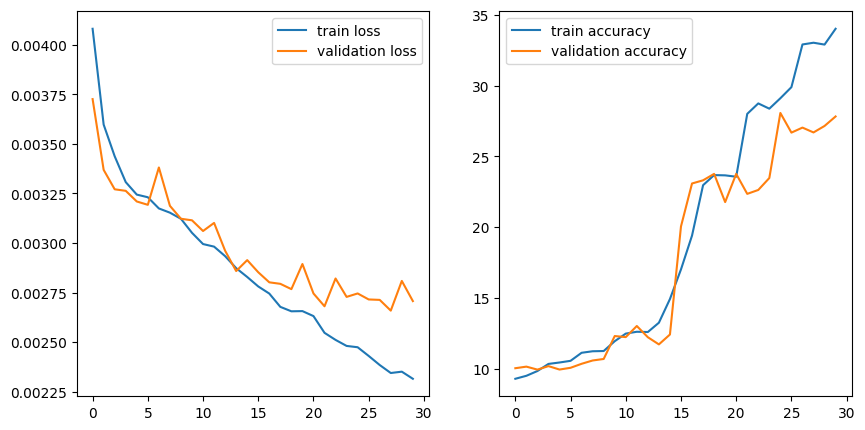

In [19]:
epochs = len(step_2_progress['train_loss'])
plt.figure(figsize=(10, 5))

# plot loss
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), np.asarray(step_2_progress['train_loss']), label='train loss')
plt.plot(np.arange(epochs), np.asarray(step_2_progress['validation_loss']), label='validation loss')
plt.legend()

# plot accuracy
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), np.asarray(step_2_progress['train_accuracy']), label='train accuracy')
plt.plot(np.arange(epochs), np.asarray(step_2_progress['validation_accuracy']), label='validation accuracy')
plt.legend()

In [20]:
# set to evaluation mode
vit.eval()

# initialize variables to track testing metrics
test_correct = np.zeros(7)
test_total = np.zeros(7)
test_loss = 0

# move model to correct device
vit = vit.to(device)
vit_preprocess = vit_preprocess.to(device)

# inference mode to speed up computations
with torch.inference_mode():
    # loop through testing data
    for X, y in test_dl:
        # move data to correct device
        X = X.to(device)
        y = y.to(device)
        
        # pass data through models
        X = vit_preprocess(X)
        predictions = vit(X)
        
        # calculate loss
        loss = loss_fn(predictions, y)
        
        # calculate metrics
        predictions = torch.where(predictions.detach() >= 0.5, 1, 0)
        test_correct += (torch.logical_and(predictions, y).sum(axis=0)).cpu().numpy()
        test_total += (torch.logical_or(predictions, y).sum(axis=0)).cpu().numpy()
        test_loss += loss.detach().item()
        
# calculate metrics
test_loss = test_loss / len(test_ds)
test_accuracy = test_correct / test_total * 100
print(f"loss: {test_loss:.4f} | accuracy: {test_accuracy}")

loss: 0.0027 | accuracy: [27.24252492 77.59526938 34.7826087   0.         19.30501931  0.
 38.7755102 ]


In [21]:
# save model
torch.save(vit.state_dict(), "vit.pt")

# move model back to cpu
vit = vit.cpu()
vit_preprocess = vit_preprocess.cpu()

# Vision Transformers for Multi-Class Classification
---

Surprisingly, the training accuracy does not rise significantly throughout the training process but the validation accuracy continues to rise. The training loss and validation loss displays a decreasing trend with the validation loss being constantly less than the training loss. This hints that the model could be trained for way more epochs.

**Test results:** <br>
Cross Entropy Loss: 0.0160<br>
Accuracy: 72.0% <br>

<table style="float:left; margin-left: 1rem;">
    <tr><td><b>Class</b></td><td><b>Precision</b></td><td><b>Recall</b></td></tr>
    <tr><td>MEL</td><td>0.52</td><td>0.05</td></tr>
    <tr><td>NV</td><td>0.76</td><td>0.98</td></tr>
    <tr><td>BCC</td><td>0.50</td><td>0.47</td></tr>
    <tr><td>AKIEC</td><td>0.00</td><td>0.00</td></tr>
    <tr><td>BKL</td><td>0.44</td><td>0.26</td></tr>
    <tr><td>DF</td><td>0.00</td><td>0.00</td></tr>
    <tr><td>VASC</td><td>0.80</td><td>0.43</td></tr>
</table>


In [22]:
def get_vit():
    from torchvision.models import vit_b_32, ViT_B_32_Weights
    
    weights = ViT_B_32_Weights.IMAGENET1K_V1
    model = vit_b_32(weights=weights)
    model.heads = torch.nn.Sequential(
        torch.nn.Dropout(0.2),
        torch.nn.Linear(768, 128),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(128, 32),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(32, 7)
    )
    preprocess = weights.transforms()
    return model, preprocess

# initialize model, loss and optimizer
# label smoothing is recommended with cutmix and mixup
vit_mc, vit_preprocess = get_vit()
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optim = torch.optim.Adamax(vit_mc.parameters())

def train(epochs: int, verbose: int = 1):
    global vit_mc, vit_preprocess, loss_fn, optim
    
    # track training progress
    progress = {
        "train_loss": [],
        "train_accuracy": [],
        "validation_loss": [],
        "validation_accuracy": []
    }
    
    # move models to correct device
    vit_mc = vit_mc.to(device)
    vit_preprocess = vit_preprocess.to(device)
    for epoch in range(epochs):
        # set to training mode
        vit_mc.train()
        
        # initialize variables to track training metrics
        train_correct = 0
        train_loss = 0
        
        for X, y in train_dl:
            # move data to correct device
            X = X.to(device)
            y = y.to(device)
            
            # calculate classes
            y = torch.argmax(y, axis=1)
            
            # pass data through models
            X = vit_preprocess(X)
            X = augmentation_model(X)
            X, aug_y = cutmix_or_mixup(X, y)
            predictions = vit_mc(X)
            
            # calculate loss
            loss = loss_fn(predictions, aug_y)
            
            # calculate metrics
            train_correct += (torch.argmax(predictions, axis=1) == y).type(torch.int).sum().item()
            train_loss += loss.detach().item()
            
            # update weights
            optim.zero_grad()
            loss.backward()
            optim.step()
            
        # calculate metrics
        train_loss = train_loss / len(train_ds)
        train_accuracy = train_correct / len(train_ds) * 100
        
        # append to list for plotting
        progress['train_loss'].append(train_loss)
        progress['train_accuracy'].append(train_accuracy)
        
        # set to evaluation mode
        vit_mc.eval()
        
        # initialize variables to track validation metrics
        validation_correct = 0
        validation_loss = 0
        
        # inference mode to speed up computations
        with torch.inference_mode():
            # loop through validation data
            for X, y in validation_dl:
                # move data to correct device
                X = X.to(device)
                y = y.to(device)
                    
                # calculate classes
                y = torch.argmax(y, axis=1)
                
                # pass data through models
                X = vit_preprocess(X)
                predictions = vit_mc(X)
                
                # calculate loss
                loss = loss_fn(predictions, y)
                
                # calculate metrics
                validation_correct += (torch.argmax(predictions, axis=1) == y).type(torch.int).sum().item()
                validation_loss += loss.detach().item()
                
        # calculate metrics
        validation_loss = validation_loss / len(validation_ds)
        validation_accuracy = validation_correct / len(validation_ds) * 100
        
        # append to list for plotting
        progress['validation_loss'].append(validation_loss)
        progress['validation_accuracy'].append(validation_accuracy)
        
        # show progress
        if epoch % verbose == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:<3}: loss: {train_loss:.4f} | accuracy: {train_accuracy:.2f}% | validation loss: {validation_loss:.4f} | validation accuracy: {validation_accuracy:.2f}%")
            
    return progress


# train only head
for param in vit_mc.parameters():
    param.require_grad = False
for param in vit_mc.heads.parameters():
    param.require_grad = True
step_1_progress = train(1)

for param in vit_mc.parameters():
    param.require_grad = True
step_2_progress = train(30)

Epoch 0  : loss: 0.0210 | accuracy: 65.57% | validation loss: 0.0192 | validation accuracy: 66.95%
Epoch 0  : loss: 0.0198 | accuracy: 66.92% | validation loss: 0.0186 | validation accuracy: 66.95%
Epoch 1  : loss: 0.0194 | accuracy: 66.90% | validation loss: 0.0183 | validation accuracy: 66.95%
Epoch 2  : loss: 0.0193 | accuracy: 66.87% | validation loss: 0.0181 | validation accuracy: 66.95%
Epoch 3  : loss: 0.0191 | accuracy: 66.83% | validation loss: 0.0178 | validation accuracy: 66.95%
Epoch 4  : loss: 0.0192 | accuracy: 66.92% | validation loss: 0.0177 | validation accuracy: 66.95%
Epoch 5  : loss: 0.0191 | accuracy: 66.88% | validation loss: 0.0180 | validation accuracy: 66.95%
Epoch 6  : loss: 0.0190 | accuracy: 66.95% | validation loss: 0.0174 | validation accuracy: 67.35%
Epoch 7  : loss: 0.0187 | accuracy: 66.87% | validation loss: 0.0176 | validation accuracy: 67.25%
Epoch 8  : loss: 0.0186 | accuracy: 67.02% | validation loss: 0.0171 | validation accuracy: 68.30%
Epoch 9  :

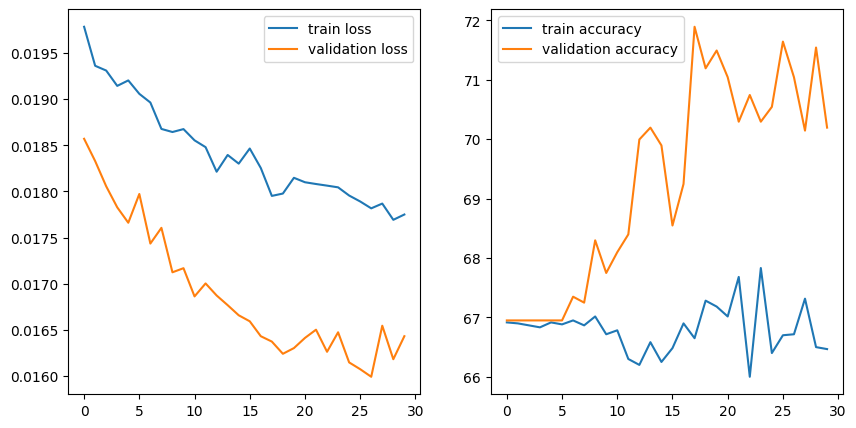

In [23]:
epochs = len(step_2_progress['train_loss'])
plt.figure(figsize=(10, 5))

# plot loss
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), np.asarray(step_2_progress['train_loss']), label='train loss')
plt.plot(np.arange(epochs), np.asarray(step_2_progress['validation_loss']), label='validation loss')
plt.legend()

# plot accuracy
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), np.asarray(step_2_progress['train_accuracy']), label='train accuracy')
plt.plot(np.arange(epochs), np.asarray(step_2_progress['validation_accuracy']), label='validation accuracy')
plt.legend()

In [24]:
# set to evaluation mode
vit_mc.eval()

# initialize variables to track testing metrics
test_predictions = torch.tensor([])
test_y = torch.tensor([])
test_loss = 0

# move model to correct device
vit_mc = vit_mc.to(device)
vit_preprocess = vit_preprocess.to(device)

# inference mode to speed up computations
with torch.inference_mode():
    # loop through testing data
    for X, y in test_dl:
        # move data to correct device
        X = X.to(device)
        y = y.to(device)
        
        # calculate classes
        y = torch.argmax(y, axis=1)
        
        # pass data through models
        X = vit_preprocess(X)
        predictions = vit_mc(X)
        
        # calculate loss
        loss = loss_fn(predictions, y)
        
        # calculate metrics
        test_predictions = torch.cat([test_predictions, torch.argmax(predictions.detach().cpu(), axis=1)])
        test_y = torch.cat([test_y, y.detach().cpu()])
        test_loss += loss.detach().item()

# calculate metrics
test_loss = test_loss / len(test_ds)
test_predictions = test_predictions.numpy()
test_y = test_y.numpy()
print(f"loss: {test_loss:.4f}")
print(classification_report(test_y, test_predictions))

loss: 0.0164
              precision    recall  f1-score   support

         0.0       0.68      0.07      0.12       223
         1.0       0.70      0.99      0.82      1341
         2.0       0.86      0.12      0.21       103
         3.0       0.00      0.00      0.00        65
         4.0       0.59      0.09      0.16       220
         5.0       0.00      0.00      0.00        23
         6.0       0.67      0.71      0.69        28

    accuracy                           0.70      2003
   macro avg       0.50      0.28      0.28      2003
weighted avg       0.66      0.70      0.60      2003



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# save model
torch.save(vit_mc.state_dict(), "vit_mc.pt")

# move model back to cpu
vit_mc = vit_mc.cpu()
vit_preprocess = vit_preprocess.cpu()

# Custom Xception Inspired Model
---
**Reference paper:** <br>
He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778). 
https://doi.org/10.48550/arXiv.1512.03385

In [26]:
class XceptionBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, relu_first: bool = True):
        super().__init__()
        
        # there are 2 choices in the XceptionBlock
        # first is whether ReLU is done before the first convolution
        # which is only used for the first XceptionBlock in the model
        # second is whether the pooling or a 3rd convolution is used
        # which is dependent on whether the input size and output size 
        # are the same
        self.relu_first = relu_first
        self.input_size = input_size
        self.output_size = output_size
        
        # Xception uses depth-wise separable convolution layers
        # groups = input_size converts convolution layers into 
        # depth-wise separable convolutions layers
        # first convolution block
        self.activation1 = torch.nn.ReLU()
        self.convolution1 = torch.nn.Conv2d(input_size, output_size, 3, padding=1, groups=input_size, padding_mode="reflect")
        self.batch_norm1 = torch.nn.BatchNorm2d(output_size)
        
        # second convolution block
        self.activation2 = torch.nn.ReLU()
        self.convolution2 = torch.nn.Conv2d(output_size, output_size, 3, padding=1, groups=output_size, padding_mode="reflect")
        self.batch_norm2 = torch.nn.BatchNorm2d(output_size)
        
        if self.input_size == self.output_size:
            # used if input size and output size are the same
            self.activation3 = torch.nn.ReLU()
            self.convolution3 = torch.nn.Conv2d(output_size, output_size, 3, padding=1, groups=output_size, padding_mode="reflect")
            self.batch_norm3 = torch.nn.BatchNorm2d(output_size)
        else:
            # used if input size and output size are different
            self.pooling = torch.nn.MaxPool2d(3, padding=1, stride=2)
            self.parallel_convolution = torch.nn.Conv2d(input_size, output_size, 1, stride=2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # whether ReLU is done first
        if self.relu_first:
            y = self.activation1(x)
        else:
            y = x
            
        # first convolution block
        y = self.convolution1(y)
        y = self.batch_norm1(y)
        
        # second convolution block
        y = self.activation2(y)
        y = self.convolution2(y)
        y = self.batch_norm2(y)
        
        # either the pooling block or third convolution block
        if self.input_size != self.output_size:
            y = self.pooling(y)
            x = self.parallel_convolution(x)
        else:
            y = self.activation3(y)
            y = self.convolution3(y)
            y = self.batch_norm3(y)
        
        # similar to resnet 
        # add output of block to input
        y += x
        return y
    
class MiniXception(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # shrink input size to decrease computation
        self.initial = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, 3, stride=2, padding=1, padding_mode="reflect"),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )
        
        # entry Xception layers
        layers = [64, 128, 256]
        blocks = []
        for i in range(len(layers) - 1):
            blocks.append(XceptionBlock(layers[i], layers[i + 1], i != 0))
        self.entry_blocks = torch.nn.ModuleList(blocks)
        
        # middle Xception layers
        blocks = []
        for i in range(1):
            blocks.append(XceptionBlock(layers[-1], layers[-1]))
        self.middle_blocks = torch.nn.ModuleList(blocks)
        
        # tail Xception layers
        self.tail = torch.nn.Sequential(
            XceptionBlock(layers[-1], 512, i != 0),
            torch.nn.Conv2d(512, 1024, 3, stride=2, padding=1, padding_mode="reflect"),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(7)
        )
        
        # fully connected layers
        self.fc = torch.nn.Sequential(
            torch.nn.Dropout(0.2),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(512, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(64, 7)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # pass through convolution layers
        x = self.initial(x)
        for layer in self.entry_blocks:
            x = layer(x)
        for layer in self.middle_blocks:
            x = layer(x)
        x = self.tail(x)
        
        # flatten the tensor
        n, c, w, h = x.shape
        x = torch.reshape(x, (n, c * w * h))
        
        # pass through fully connected layers
        x = self.fc(x)
        return x

# Custom Xception Model for Multi-label Classification
---

Unlike the pre-trained resnet18 model, the custom Xception Model is able to correctly predict the `DF` class occasionally. Although, it should be noted that the validation loss started to rise after 25 epochs which suggests that the model maybe starting to overfit the training data. 

**Test results:** <br>
Binary Cross Entropy Loss: 0.0029<br>
Accuracy:
<table style="float:left; margin-left: 1rem;">
    <tr><td><b>Class</b></td><td><b>Accuracy</b></td></tr>
    <tr><td>MEL</td><td>32.23%</td></tr>
    <tr><td>NV</td><td>81.02%</td></tr>
    <tr><td>BCC</td><td>48.48%</td></tr>
    <tr><td>AKIEC</td><td>28.57%</td></tr>
    <tr><td>BKL</td><td>37.19%</td></tr>
    <tr><td>DF</td><td>19.35%</td></tr>
    <tr><td>VASC</td><td>68.97%</td></tr>
</table>

In [27]:
# initialize model, loss and optimizer
mini_xception = MiniXception()
loss_fn = torch.nn.BCELoss()
optim = torch.optim.Adamax(mini_xception.parameters())
sigmoid = torch.nn.Sigmoid()

def train(epochs: int, verbose: int = 1):
    global mini_xception, sigmoid, loss_fn, optim
    
    # initialize parameters
    num_classes = 7
    
    # track training progress
    progress = {
        "train_loss": [],
        "train_accuracy": [],
        "validation_loss": [],
        "validation_accuracy": []
    }
    
    # move models to correct device
    mini_xception = mini_xception.to(device)
    sigmoid = sigmoid.to(device)
    for epoch in range(epochs):
        # set to train mode
        mini_xception.train()
        
        # initialize variables to track training metrics
        train_correct = np.zeros(7)
        train_total = np.zeros(7)
        train_loss = 0
        
        # loop through training data
        for X, y in train_dl:
            # move data to correct device
            X = X.to(device)
            y = y.to(device)
            
            # pass data through models
            X = augmentation_model(X)
            predictions = mini_xception(X)
            predictions = sigmoid(predictions)
            
            # calcualte loss
            loss = loss_fn(predictions, y)
            
            # calculate metrics
            predictions = torch.where(predictions.detach() >= 0.5, 1, 0)
            train_correct += (torch.logical_and(predictions, y).sum(axis=0)).cpu().numpy()
            train_total += (torch.logical_or(predictions, y).sum(axis=0)).cpu().numpy()
            train_loss += loss.detach().item()
            
            # update weights
            optim.zero_grad()
            loss.backward()
            optim.step()
            
        # calculate metrics
        train_loss = train_loss / len(train_ds)
        train_accuracy = np.sum(train_correct / train_total * 100) / num_classes
        
        # append to list for plotting
        progress['train_loss'].append(train_loss)
        progress['train_accuracy'].append(train_accuracy)

        # set to evaluation mode
        mini_xception.eval()
        
        # initialize variables to track validation metrics
        validation_correct = np.zeros(7)
        validation_total = np.zeros(7)
        validation_loss = 0
        
        # inference mode to speed up computations
        with torch.inference_mode():
            # loop through validation data
            for X, y in validation_dl:
                # move data to correct device
                X = X.to(device)
                y = y.to(device)
                
                # pass data through models
                predictions = mini_xception(X)
                predictions = sigmoid(predictions)
                
                # calculate loss
                loss = loss_fn(predictions, y)
                
                # calculate metrics
                predictions = torch.where(predictions.detach() >= 0.5, 1, 0)
                validation_correct += (torch.logical_and(predictions, y).sum(axis=0)).cpu().numpy()
                validation_total += (torch.logical_or(predictions, y).sum(axis=0)).cpu().numpy()
                validation_loss += loss.detach().item()
        
        # calculate metrics
        validation_loss = validation_loss / len(validation_ds)
        validation_accuracy = np.sum(validation_correct / validation_total * 100) / num_classes
        
        # append to list for plotting
        progress['validation_loss'].append(validation_loss)
        progress['validation_accuracy'].append(validation_accuracy)

        # show progress
        if epoch % verbose == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:<3}: loss: {train_loss:.4f} | accuracy: {train_accuracy:.2f} | validation loss: {validation_loss:.4f} | validation accuracy: {validation_accuracy:.2f}")
        
    return progress

# train the model
progress = train(50)

Epoch 0  : loss: 0.0036 | accuracy: 10.26 | validation loss: 0.0032 | validation accuracy: 10.55
Epoch 1  : loss: 0.0031 | accuracy: 12.47 | validation loss: 0.0031 | validation accuracy: 12.68
Epoch 2  : loss: 0.0029 | accuracy: 14.90 | validation loss: 0.0031 | validation accuracy: 15.03
Epoch 3  : loss: 0.0028 | accuracy: 16.08 | validation loss: 0.0029 | validation accuracy: 15.35
Epoch 4  : loss: 0.0027 | accuracy: 16.87 | validation loss: 0.0029 | validation accuracy: 16.50
Epoch 5  : loss: 0.0026 | accuracy: 18.90 | validation loss: 0.0029 | validation accuracy: 17.12
Epoch 6  : loss: 0.0026 | accuracy: 19.41 | validation loss: 0.0028 | validation accuracy: 20.46
Epoch 7  : loss: 0.0025 | accuracy: 21.75 | validation loss: 0.0027 | validation accuracy: 19.76
Epoch 8  : loss: 0.0025 | accuracy: 21.90 | validation loss: 0.0028 | validation accuracy: 19.44
Epoch 9  : loss: 0.0024 | accuracy: 24.23 | validation loss: 0.0027 | validation accuracy: 20.35
Epoch 10 : loss: 0.0024 | accu

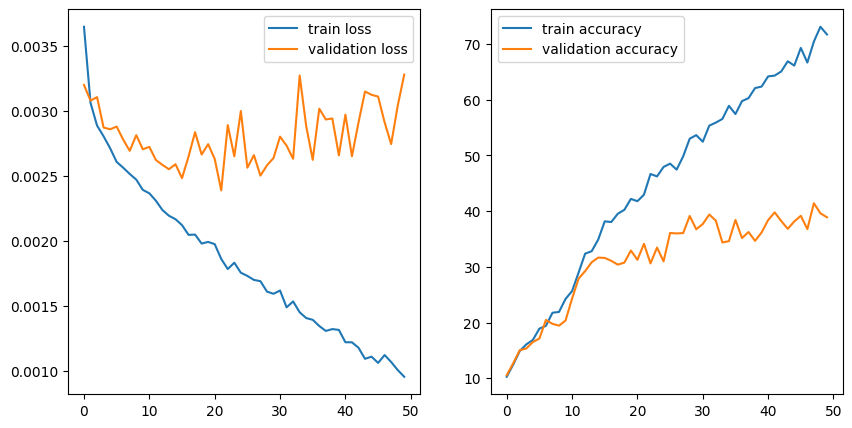

In [28]:
epochs = len(progress['train_loss'])
plt.figure(figsize=(10, 5))

# plot loss
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), np.asarray(progress['train_loss']), label='train loss')
plt.plot(np.arange(epochs), np.asarray(progress['validation_loss']), label='validation loss')
plt.legend()

# plot accuracy
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), np.asarray(progress['train_accuracy']), label='train accuracy')
plt.plot(np.arange(epochs), np.asarray(progress['validation_accuracy']), label='validation accuracy')
plt.legend()

In [29]:
# set to evaluation mode
mini_xception.eval()

# initialize variables to track testing metrics
test_correct = np.zeros(7)
test_total = np.zeros(7)
test_loss = 0

# move models to correct device
mini_xception = mini_xception.to(device)
sigmoid = sigmoid.to(device)

# inference mode to speed up computations
with torch.inference_mode():
    # loop through testing data
    for X, y in test_dl:
        # move data to correcte device
        X = X.to(device)
        y = y.to(device)
        
        # pass data through models
        predictions = mini_xception(X)
        predictions = sigmoid(predictions)
        
        # calculate loss
        loss = loss_fn(predictions, y)
        
        # calculate metrics
        predictions = torch.where(predictions.detach() >= 0.5, 1, 0)
        test_correct += (torch.logical_and(predictions, y).sum(axis=0)).cpu().numpy()
        test_total += (torch.logical_or(predictions, y).sum(axis=0)).cpu().numpy()
        test_loss += loss.detach().item()
        
# calculate metrics
test_loss = test_loss / len(test_ds)
test_accuracy = test_correct / test_total * 100
print(f"loss: {test_loss:.4f} | accuracy: {test_accuracy}")

loss: 0.0028 | accuracy: [36.36363636 81.53638814 40.16393443 23.25581395 34.73684211 21.42857143
 57.14285714]


In [30]:
# save model
torch.save(mini_xception.state_dict(), "mini_xception.pt")

# move model back to cpu
mini_xception = mini_xception.cpu()

# Custom Xception Model for Multi-Class Classification
---

The Xception model actually performs similarly to the pre-trained models when it comes to multi-class classification. However, it could be even better as after 50 epochs, the model does not show signs of overfitting yet. The model's validation accuracy is still rising and validation loss is still decreasing. 

**Test results:** <br>
Cross Entropy Loss: 0.0144<br>
Accuracy: 78.0% <br>

<table style="float:left; margin-left: 1rem;">
    <tr><td><b>Class</b></td><td><b>Precision</b></td><td><b>Recall</b></td></tr>
    <tr><td>MEL</td><td>0.63</td><td>0.31</td></tr>
    <tr><td>NV</td><td>0.80</td><td>0.97</td></tr>
    <tr><td>BCC</td><td>0.73</td><td>0.43</td></tr>
    <tr><td>AKIEC</td><td>0.71</td><td>0.31</td></tr>
    <tr><td>BKL</td><td>0.68</td><td>0.43</td></tr>
    <tr><td>DF</td><td>0.00</td><td>0.00</td></tr>
    <tr><td>VASC</td><td>0.88</td><td>0.79</td></tr>
</table>

In [31]:
# initialize model, loss and optimizer
# label smoothing is recommended with cutmix and mixup
mini_xception_mc = MiniXception()
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optim = torch.optim.Adamax(mini_xception_mc.parameters())

def train(epochs: int, verbose: int = 1):
    global mini_xception_mc, loss_fn, optim
    
    # track training progress
    progress = {
        "train_loss": [],
        "train_accuracy": [],
        "validation_loss": [],
        "validation_accuracy": []
    }
    
    # move model to correct device
    mini_xception_mc = mini_xception_mc.to(device)
    for epoch in range(epochs):
        # set to train mode
        mini_xception_mc.train()
        
        # initialize variables to track training metrics
        train_correct = 0
        train_loss = 0
        
        # loop through training data
        for X, y in train_dl:
            # move data to correct device
            X = X.to(device)
            y = y.to(device)
                
            # calculate classes
            y = torch.argmax(y, axis=1)
            
            # pass data through models
            X = augmentation_model(X)
            X, aug_y = cutmix_or_mixup(X, y)
            predictions = mini_xception_mc(X)
            
            # calculate loss
            loss = loss_fn(predictions, aug_y)
            
            # calculate metrics
            train_correct += (torch.argmax(predictions, axis=1) == y).type(torch.int).sum().item()
            train_loss += loss.detach().item()
            
            # update weights
            optim.zero_grad()
            loss.backward()
            optim.step()
            
        # calculate metrics
        train_loss = train_loss / len(train_ds)
        train_accuracy = train_correct / len(train_ds) * 100
        
        # append to list for plotting
        progress['train_loss'].append(train_loss)
        progress['train_accuracy'].append(train_accuracy)

        # set to evaluation mode
        mini_xception_mc.eval()
        
        # initialize variables to track validation metrics
        validation_correct = 0
        validation_loss = 0
        with torch.inference_mode():
            for X, y in validation_dl:
                # move data to correct device
                X = X.to(device)
                y = y.to(device)
                    
                # calculate classes
                y = torch.argmax(y, axis=1)
                
                # pass data through models
                predictions = mini_xception_mc(X)
                
                # calculate loss
                loss = loss_fn(predictions, y)
                
                # calculate metrics
                validation_correct += (torch.argmax(predictions, axis=1) == y).type(torch.int).sum().item()
                validation_loss += loss.detach().item()
                
        # calculate metrics
        validation_loss = validation_loss / len(validation_ds)
        validation_accuracy = validation_correct / len(validation_ds) * 100
        
        # append to list for plotting
        progress['validation_loss'].append(validation_loss)
        progress['validation_accuracy'].append(validation_accuracy)

        if epoch % verbose == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:<3}: loss: {train_loss:.4f} | accuracy: {train_accuracy:.2f} | validation loss: {validation_loss:.4f} | validation accuracy: {validation_accuracy:.2f}")
    return progress

# train model
progress = train(50)

Epoch 0  : loss: 0.0194 | accuracy: 66.00 | validation loss: 0.0177 | validation accuracy: 66.90
Epoch 1  : loss: 0.0186 | accuracy: 66.90 | validation loss: 0.0177 | validation accuracy: 68.50
Epoch 2  : loss: 0.0183 | accuracy: 67.00 | validation loss: 0.0170 | validation accuracy: 70.44
Epoch 3  : loss: 0.0181 | accuracy: 67.23 | validation loss: 0.0167 | validation accuracy: 72.29
Epoch 4  : loss: 0.0181 | accuracy: 67.22 | validation loss: 0.0164 | validation accuracy: 72.09
Epoch 5  : loss: 0.0180 | accuracy: 67.27 | validation loss: 0.0167 | validation accuracy: 71.29
Epoch 6  : loss: 0.0177 | accuracy: 67.53 | validation loss: 0.0164 | validation accuracy: 73.54
Epoch 7  : loss: 0.0176 | accuracy: 67.86 | validation loss: 0.0162 | validation accuracy: 73.09
Epoch 8  : loss: 0.0176 | accuracy: 68.36 | validation loss: 0.0159 | validation accuracy: 74.09
Epoch 9  : loss: 0.0177 | accuracy: 67.65 | validation loss: 0.0160 | validation accuracy: 74.14
Epoch 10 : loss: 0.0174 | accu

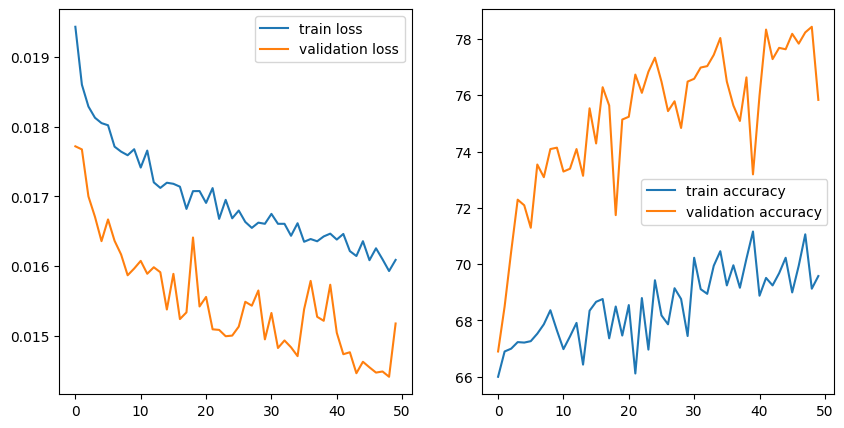

In [32]:
epochs = len(progress['train_loss'])
plt.figure(figsize=(10, 5))

# plot loss
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), np.asarray(progress['train_loss']), label='train loss')
plt.plot(np.arange(epochs), np.asarray(progress['validation_loss']), label='validation loss')
plt.legend()

# plot accuracy
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), np.asarray(progress['train_accuracy']), label='train accuracy')
plt.plot(np.arange(epochs), np.asarray(progress['validation_accuracy']), label='validation accuracy')
plt.legend()

In [33]:
# set to evaluation mode
mini_xception_mc.eval()

# initialize variables to track testing metrics
test_predictions = torch.tensor([])
test_y = torch.tensor([])
test_loss = 0

# move model to correct device
mini_xception_mc = mini_xception_mc.to(device)

# inference mode to speed up computations
with torch.inference_mode():
    # loop through testing data
    for X, y in test_dl:
        # move data to correct device
        X = X.to(device)
        y = y.to(device)
        
        # calculate classes
        y = torch.argmax(y, axis=1)
        
        # pass data through models
        predictions = mini_xception_mc(X)
        
        # calculate loss
        loss = loss_fn(predictions, y)
        
        # calculate metrics
        test_predictions = torch.cat([test_predictions, torch.argmax(predictions.detach().cpu(), axis=1)])
        test_y = torch.cat([test_y, y.detach().cpu()])
        test_loss += loss.detach().item()
        
# calculate metrics
test_loss = test_loss / len(test_ds)
test_predictions = test_predictions.numpy()
test_y = test_y.numpy()
print(f"loss: {test_loss:.4f}")
print(classification_report(test_y, test_predictions))

loss: 0.0148
              precision    recall  f1-score   support

         0.0       0.46      0.72      0.56       223
         1.0       0.88      0.91      0.89      1341
         2.0       0.72      0.59      0.65       103
         3.0       0.59      0.35      0.44        65
         4.0       0.64      0.35      0.45       220
         5.0       0.00      0.00      0.00        23
         6.0       0.95      0.68      0.79        28

    accuracy                           0.78      2003
   macro avg       0.60      0.51      0.54      2003
weighted avg       0.78      0.78      0.77      2003



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
# save model
torch.save(mini_xception_mc.state_dict(), "mini_xception_mc.pt")

# move model back to cpu
mini_xception_mc = mini_xception_mc.cpu()

# Custom ViT Inspired Model
---
**Reference paper:** <br>
Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2020). An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929. https://doi.org/10.48550/arXiv.2010.11929


In [35]:
class EncoderBlock(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.channels = 197
        self.embedding_dim = 128
        self.norm1 = torch.nn.LayerNorm((self.channels, self.embedding_dim))
        
        self.heads = 4
        self.attention_dropout_rate = 0.1
        self.MSA = torch.nn.MultiheadAttention(self.embedding_dim, self.heads, dropout=self.attention_dropout_rate, batch_first=True)
        
        self.dropout_rate = 0.1
        self.dropout = torch.nn.Dropout(self.dropout_rate)
        
        self.norm2 = torch.nn.LayerNorm((self.channels, self.embedding_dim))
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(self.embedding_dim, self.embedding_dim),
            torch.nn.GELU(),
            torch.nn.Dropout(self.dropout_rate),
            torch.nn.Linear(self.embedding_dim, self.embedding_dim),
            torch.nn.Dropout(self.dropout_rate)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # the encoder block has a similar feature to resnet 
        # where the input is added to the output of a layer
        y = x
        
        x = self.norm1(x)
        x, _ = self.MSA(x, x, x)
        x = self.dropout(x)
        x += y
        
        # this will be added back to the output again
        y = x
        x = self.norm2(x)
        
        # slight difference between flax.nn.Dense and torch.nn.Linear
        # flax.nn.Dense works on > 2 dimension
        # torch.nn.Linear only works on 2 dimension
        n, c, f = x.shape
        x = torch.reshape(x, (n * c, f))
        x = self.mlp(x)
        x = torch.reshape(x, (n, c, f))
        x += y
        
        return x

class MiniViT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = (224, 224)
        
        # the output of the convolution will be n X 14 X 14 X 768
        self.input_channels = 3
        self.patch_embedding_dim = 128
        self.patch_size = 16
        self.num_patches = int(self.input_shape[0] * self.input_shape[1] / (self.patch_size ** 2)) # 196
        self.image_to_patch = torch.nn.Conv2d(self.input_channels, self.patch_embedding_dim, self.patch_size, stride=self.patch_size)
        
        self.class_token = torch.nn.Parameter(torch.randn(self.patch_embedding_dim))
        
        # the std_dev value was taken from the github implementation of the ViT model
        self.std_dev = 0.02
        self.positional_embedding = torch.nn.Parameter(torch.randn(1, 1 + self.num_patches, self.patch_embedding_dim) * self.std_dev) 
        
        self.num_encoders = 3
        self.encoder = torch.nn.ModuleList([EncoderBlock() for _ in range(self.num_encoders)])
        
        self.num_classes = 7
        self.mlp = torch.nn.Linear(self.patch_embedding_dim, self.num_classes)
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.image_to_patch(x)
        
        # convert into linear
        n, c, h, w = x.shape
        x = torch.reshape(x, (n, h * w, c)) # x has shape n x 196 x 768
        
        # concat class_token
        class_token = torch.broadcast_to(self.class_token, (n, 1, c))
        x = torch.cat([class_token, x], axis=1)
        
        # add positional embedding
        x = x + self.positional_embedding
        
        # pass through encoder transformer
        for layer in self.encoder:
            x = layer(x)
        
        # extract class token
        x = x[:, 0, :].squeeze()
        
        # get logits
        x = self.mlp(x)
        return x

# Custom ViT Model for Multi-Label Classification
---

Just based on the accuracies for each class, it is obvious that the vision transformer model has completely failed to learn how to classify the various types of skin cancers. Although, even after 50 epochs, the model's validation loss and validation accuracy is hugging the train loss and train accuracy closely and both are still showing a clear decreasing and increasing trend respectively. This suggests that the vision transformer model has not trained for sufficient epochs and a higher epoch count ought to be used. 

**Test results:** <br>
Binary Cross Entropy Loss: 0.0029<br>
Accuracy:
<table style="float:left; margin-left: 1rem;">
    <tr><td><b>Class</b></td><td><b>Accuracy</b></td></tr>
    <tr><td>MEL</td><td>3.08%</td></tr>
    <tr><td>NV</td><td>75.98%</td></tr>
    <tr><td>BCC</td><td>2.91%</td></tr>
    <tr><td>AKIEC</td><td>4.23%</td></tr>
    <tr><td>BKL</td><td>20.96%</td></tr>
    <tr><td>DF</td><td>0.00%</td></tr>
    <tr><td>VASC</td><td>3.57%</td></tr>
</table>

In [36]:
# initialize model, loss and optimizer
mini_vit = MiniViT()
loss_fn = torch.nn.BCELoss()
optim = torch.optim.Adamax(mini_vit.parameters())
sigmoid = torch.nn.Sigmoid()

def train(epochs: int, verbose: int = 1):
    global mini_vit, sigmoid, loss_fn, optim
    
    # initialize parameters
    num_classes = 7
    
    # track training progress
    progress = {
        "train_loss": [],
        "train_accuracy": [],
        "validation_loss": [],
        "validation_accuracy": []
    }
    
    # move models to correct device
    mini_vit = mini_vit.to(device)
    sigmoid = sigmoid.to(device)
    for epoch in range(epochs):
        # set to train mode
        mini_vit.train()
        
        # initialize variables to track training metrics
        train_correct = np.zeros(num_classes)
        train_total = np.zeros(num_classes)
        train_loss = 0
        
        # loop through training data
        for X, y in train_dl:
            # move data to correct device
            X = X.to(device)
            y = y.to(device)
            
            # pass data through models
            X = augmentation_model(X)
            predictions = mini_vit(X)
            predictions = sigmoid(predictions)
            
            # calculate loss
            loss = loss_fn(predictions, y)
            
            # calculate metrics
            predictions = torch.where(predictions.detach() >= 0.5, 1, 0)
            train_correct += (torch.logical_and(predictions, y).sum(axis=0)).cpu().numpy()
            train_total += (torch.logical_or(predictions, y).sum(axis=0)).cpu().numpy()
            train_loss += loss.detach().item()
            
            # update weights
            optim.zero_grad()
            loss.backward()
            optim.step()
        
        # calculate metrics
        train_loss = train_loss / len(train_ds)
        train_accuracy = np.sum(train_correct / train_total * 100) / num_classes
        
        # append to list for plotting
        progress['train_loss'].append(train_loss)
        progress['train_accuracy'].append(train_accuracy)

        # set to evaluation mode
        mini_vit.eval()
        
        # initialize variables to track validation metrics
        validation_correct = np.zeros(num_classes)
        validation_total = np.zeros(num_classes)
        validation_loss = 0
        
        # inference mode to speed up computations 
        with torch.inference_mode():
            # loop through validation data
            for X, y in validation_dl:
                # move data to correct device
                X = X.to(device)
                y = y.to(device)
                
                # pass data through models
                predictions = mini_vit(X)
                predictions = sigmoid(predictions)
                
                # calculate loss
                loss = loss_fn(predictions, y)
                
                # calculate metrics
                predictions = torch.where(predictions.detach() >= 0.5, 1, 0)
                validation_correct += (torch.logical_and(predictions, y).sum(axis=0)).cpu().numpy()
                validation_total += (torch.logical_or(predictions, y).sum(axis=0)).cpu().numpy()
                validation_loss += loss.detach().item()
                
        # calculate metrics
        validation_loss = validation_loss / len(validation_ds)
        validation_accuracy = np.sum(validation_correct / validation_total * 100) / num_classes
        
        # append to list for plotting
        progress['validation_loss'].append(validation_loss)
        progress['validation_accuracy'].append(validation_accuracy)

        # show progress
        if epoch % verbose == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:<3}: loss: {train_loss:.4f} | accuracy: {train_accuracy:.2f} | validation loss: {validation_loss:.4f} | validation accuracy: {validation_accuracy:.2f}")
            
    return progress

# train model
progress = train(50)

Epoch 0  : loss: 0.0043 | accuracy: 9.64 | validation loss: 0.0041 | validation accuracy: 9.56
Epoch 1  : loss: 0.0039 | accuracy: 9.31 | validation loss: 0.0038 | validation accuracy: 9.15
Epoch 2  : loss: 0.0036 | accuracy: 9.08 | validation loss: 0.0036 | validation accuracy: 9.04
Epoch 3  : loss: 0.0035 | accuracy: 9.42 | validation loss: 0.0034 | validation accuracy: 10.18
Epoch 4  : loss: 0.0033 | accuracy: 10.07 | validation loss: 0.0033 | validation accuracy: 10.36
Epoch 5  : loss: 0.0033 | accuracy: 10.22 | validation loss: 0.0032 | validation accuracy: 10.70
Epoch 6  : loss: 0.0033 | accuracy: 10.68 | validation loss: 0.0032 | validation accuracy: 10.94
Epoch 7  : loss: 0.0032 | accuracy: 11.03 | validation loss: 0.0032 | validation accuracy: 10.79
Epoch 8  : loss: 0.0032 | accuracy: 10.72 | validation loss: 0.0032 | validation accuracy: 11.77
Epoch 9  : loss: 0.0031 | accuracy: 11.24 | validation loss: 0.0032 | validation accuracy: 10.63
Epoch 10 : loss: 0.0031 | accuracy: 1

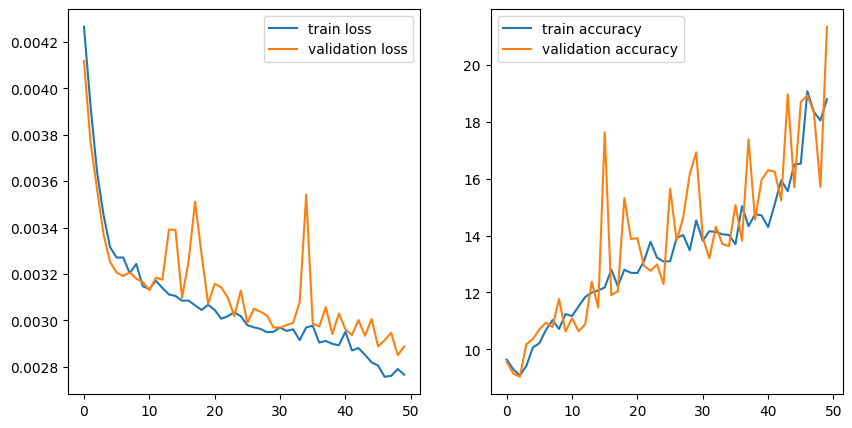

In [37]:
epochs = len(progress['train_loss'])
plt.figure(figsize=(10, 5))

# plot loss
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), np.asarray(progress['train_loss']), label='train loss')
plt.plot(np.arange(epochs), np.asarray(progress['validation_loss']), label='validation loss')
plt.legend()

# plot accuracy
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), np.asarray(progress['train_accuracy']), label='train accuracy')
plt.plot(np.arange(epochs), np.asarray(progress['validation_accuracy']), label='validation accuracy')
plt.legend()

In [38]:
# set to evaluation mode
mini_vit.eval()

# initialize variables to track validation metrics
test_correct = np.zeros(7)
test_total = np.zeros(7)
test_loss = 0

# move models to correct device
mini_vit = mini_vit.to(device)
sigmoid = sigmoid.to(device)

# inference mode to speed up computations
with torch.inference_mode():
    # loop through testing data
    for X, y in test_dl:
        # move data to correct device
        X = X.to(device)
        y = y.to(device)
        
        # pass data through models
        predictions = mini_vit(X)
        predictions = sigmoid(predictions)
        
        # calculate loss
        loss = loss_fn(predictions, y)
        
        # calculate metrics
        predictions = torch.where(predictions.detach() >= 0.5, 1, 0)
        test_correct += (torch.logical_and(predictions, y).sum(axis=0)).cpu().numpy()
        test_total += (torch.logical_or(predictions, y).sum(axis=0)).cpu().numpy()
        test_loss += loss.detach().item()
        
# calculate metrics
test_loss = test_loss / len(test_ds)
test_accuracy = test_correct / test_total * 100
print(f"loss: {test_loss:.4f} | accuracy: {test_accuracy}")

loss: 0.0029 | accuracy: [17.45454545 74.46945338  7.69230769  7.14285714 19.62962963  0.
 16.66666667]


In [39]:
# save model
torch.save(mini_vit.state_dict(), "mini_vit.pt")

# move model back to cpu
mini_vit = mini_vit.cpu() 

# Custom ViT Model for Multi-Class Classification
---

The vision transformer model here failed to predict 3 classes: `AKIEC`, `DF`, and `VASC`. Both `AKIEC` and `VASC` had non-zero precision and recalls for the pre-trained models which suggests that the pretrained models is still better. Again, after 50 epochs, the validation loss and validation accuracy is still following a decreasing and increasing trend respectively. So, this model should be trained even more.

**Test results:** <br>
Cross Entropy Loss: 0.0170<br>
Accuracy: 71.0% <br>

<table style="float:left; margin-left: 1rem;">
    <tr><td><b>Class</b></td><td><b>Precision</b></td><td><b>Recall</b></td></tr>
    <tr><td>MEL</td><td>0.52</td><td>0.15</td></tr>
    <tr><td>NV</td><td>0.74</td><td>0.97</td></tr>
    <tr><td>BCC</td><td>0.43</td><td>0.32</td></tr>
    <tr><td>AKIEC</td><td>0.00</td><td>0.00</td></tr>
    <tr><td>BKL</td><td>0.46</td><td>0.23</td></tr>
    <tr><td>DF</td><td>0.00</td><td>0.00</td></tr>
    <tr><td>VASC</td><td>0.00</td><td>0.00</td></tr>
</table>


In [40]:
# initialize model, loss and optimizer
# label smoothing is recommended with cutmix and mixup
mini_vit_mc = MiniViT()
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optim = torch.optim.Adamax(mini_vit_mc.parameters())
gpu = torch.cuda.is_available()

def train(epochs: int, verbose: int = 1):
    global mini_vit_mc, loss_fn, optim
    
    # track training progress
    progress = {
        "train_loss": [],
        "train_accuracy": [],
        "validation_loss": [],
        "validation_accuracy": []
    }
    
    # move model to correct device
    mini_vit_mc = mini_vit_mc.to(device)
    for epoch in range(epochs):
        # set to train mode
        mini_vit_mc.train()
        
        # initialize variables to track training metrics
        train_correct = 0
        train_loss = 0
        
        # loop through training data
        for X, y in train_dl:
            # move data to correct device
            X = X.to(device)
            y = y.to(device)
                
            # calculate classes
            y = torch.argmax(y, axis=1)
            
            # pass data through models
            X = augmentation_model(X)
            X, aug_y = cutmix_or_mixup(X, y)
            predictions = mini_vit_mc(X)
            
            # calculate loss
            loss = loss_fn(predictions, aug_y)
            
            # calculate metrics
            train_correct += (torch.argmax(predictions, axis=1) == y).type(torch.int).sum().item()
            train_loss += loss.detach().item()
            
            # update weights
            optim.zero_grad()
            loss.backward()
            optim.step()
            
        # calculate metrics
        train_loss = train_loss / len(train_ds)
        train_accuracy = train_correct / len(train_ds) * 100
        
        # append to list for plotting
        progress['train_loss'].append(train_loss)
        progress['train_accuracy'].append(train_accuracy)

        # set to evaluation mode
        mini_vit_mc.eval()
        
        # initialize variables to track validation metrics
        validation_correct = 0
        validation_loss = 0
        
        # inference mode to speed up computations
        with torch.inference_mode():
            # loop through validation data
            for X, y in validation_dl:
                # move data to correct device
                X = X.to(device)
                y = y.to(device)
                
                # calculate classes
                y = torch.argmax(y, axis=1)
                
                # pass data through model
                predictions = mini_vit_mc(X)
                
                # calculate loss
                loss = loss_fn(predictions, y)
                
                # calculate metrics
                validation_correct += (torch.argmax(predictions, axis=1) == y).type(torch.int).sum().item()
                validation_loss += loss.detach().item()
            
        # calculate metrics
        validation_loss = validation_loss / len(validation_ds)
        validation_accuracy = validation_correct / len(validation_ds) * 100
        
        # append to list for plotting
        progress['validation_loss'].append(validation_loss)
        progress['validation_accuracy'].append(validation_accuracy)

        # show progress
        if epoch % verbose == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:<3}: loss: {train_loss:.4f} | accuracy: {train_accuracy:.2f} | validation loss: {validation_loss:.4f} | validation accuracy: {validation_accuracy:.2f}")
            
    return progress

# train model
progress = train(50)

Epoch 0  : loss: 0.0204 | accuracy: 66.42 | validation loss: 0.0204 | validation accuracy: 66.95
Epoch 1  : loss: 0.0201 | accuracy: 66.95 | validation loss: 0.0200 | validation accuracy: 66.95
Epoch 2  : loss: 0.0197 | accuracy: 66.83 | validation loss: 0.0192 | validation accuracy: 66.60
Epoch 3  : loss: 0.0195 | accuracy: 66.70 | validation loss: 0.0187 | validation accuracy: 67.80
Epoch 4  : loss: 0.0191 | accuracy: 66.83 | validation loss: 0.0184 | validation accuracy: 67.90
Epoch 5  : loss: 0.0191 | accuracy: 66.83 | validation loss: 0.0184 | validation accuracy: 68.05
Epoch 6  : loss: 0.0191 | accuracy: 66.47 | validation loss: 0.0186 | validation accuracy: 68.00
Epoch 7  : loss: 0.0190 | accuracy: 66.08 | validation loss: 0.0182 | validation accuracy: 68.05
Epoch 8  : loss: 0.0190 | accuracy: 66.83 | validation loss: 0.0183 | validation accuracy: 68.60
Epoch 9  : loss: 0.0188 | accuracy: 66.62 | validation loss: 0.0180 | validation accuracy: 68.15
Epoch 10 : loss: 0.0189 | accu

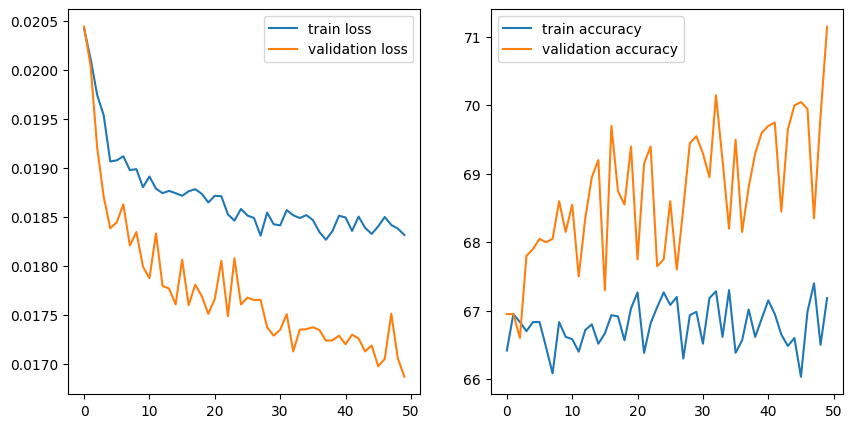

In [41]:
epochs = len(progress['train_loss'])
plt.figure(figsize=(10, 5))

# plot loss
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), np.asarray(progress['train_loss']), label='train loss')
plt.plot(np.arange(epochs), np.asarray(progress['validation_loss']), label='validation loss')
plt.legend()

# plot accuracy
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), np.asarray(progress['train_accuracy']), label='train accuracy')
plt.plot(np.arange(epochs), np.asarray(progress['validation_accuracy']), label='validation accuracy')
plt.legend()

In [42]:
# set to evaluation mode
mini_vit_mc.eval()

# initialize variables to track testing metrics
test_predictions = torch.tensor([])
test_y = torch.tensor([])
test_loss = 0

# move model to correct device
mini_vit_mc = mini_vit_mc.to(device)

# inference mode to speed up computations
with torch.inference_mode():
    # loop through test data
    for X, y in test_dl:
        # move data to correct device
        X = X.to(device)
        y = y.to(device)
        
        # calculate classes
        y = torch.argmax(y, axis=1)
        
        # pass data through model
        predictions = mini_vit_mc(X)
        
        # calculate loss
        loss = loss_fn(predictions, y)
        
        # calculate metrics
        test_predictions = torch.cat([test_predictions, torch.argmax(predictions.detach().cpu(), axis=1)])
        test_y = torch.cat([test_y, y.detach().cpu()])
        test_loss += loss.detach().item()
        
# calculate metrics
test_loss = test_loss / len(test_ds)
test_predictions = test_predictions.numpy()
test_y = test_y.numpy()
print(f"loss: {test_loss:.4f}")
print(classification_report(test_y, test_predictions))

loss: 0.0170
              precision    recall  f1-score   support

         0.0       0.46      0.10      0.16       223
         1.0       0.74      0.97      0.84      1341
         2.0       0.58      0.20      0.30       103
         3.0       0.00      0.00      0.00        65
         4.0       0.43      0.29      0.35       220
         5.0       0.00      0.00      0.00        23
         6.0       0.00      0.00      0.00        28

    accuracy                           0.71      2003
   macro avg       0.32      0.22      0.24      2003
weighted avg       0.62      0.71      0.63      2003



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
# save model
torch.save(mini_vit_mc.state_dict(), "mini_vit_mc.pt")

# move model back to cpu
mini_vit_mc = mini_vit_mc.cpu()